In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sensex/sensex.csv.xlsx


In [4]:
!pip install pmdarima
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 5.9 MB/s eta 0:00:00a 0:00:01


In [6]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [9]:
df = pd.read_excel("/kaggle/input/sensex/sensex.csv.xlsx")

In [13]:
df = df[["Open"]].copy()

In [15]:
df.describe()

,Open
count,764.000000
mean,46219.379503
std,9090.797770
min,26499.810000
25%,38871.132500
50%,44825.875000
75%,54547.405000
max,62156.480000


## ARIMA
an arima consists of 3 terms
* p is the order of the AR term 
* d is the numer of differencing required to make the time series stationary 
* q is the order of the MA term

As we see in the paramerters required by the model, any stationary time series can be modeled using arima.


## Stationarity 

Subtract the prev value from the current value. Now if we just difference once we migh t not get stationary data so we might need to do it multiple times


## ADF test

We are going to use Augumented Dickey Fuller test to check if the price is stationary 

the null hypothesis of adf is that the time series are non stationary 

So if the p-value of the test is less than 0.05 then we can reject the null hypothesis and infer that time series is stationary 


In [17]:
result = adfuller(df.Open.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")


ADF Statistic: -0.7645555572252396
P-value: 0.8293125845932671


> Autocorrelation Function (ACF)

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

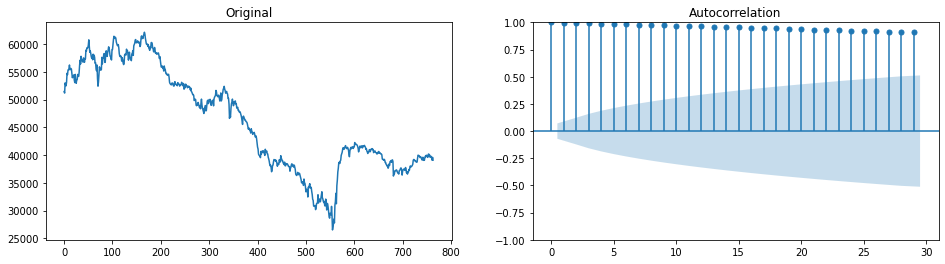

In [21]:
fig, (ax1, ax2) =plt.subplots(1,2,figsize=(16,4))

ax1.plot(df.Open)
ax1.set_title("Original")
plot_acf(df.Open, ax =ax2);

# After differencing once

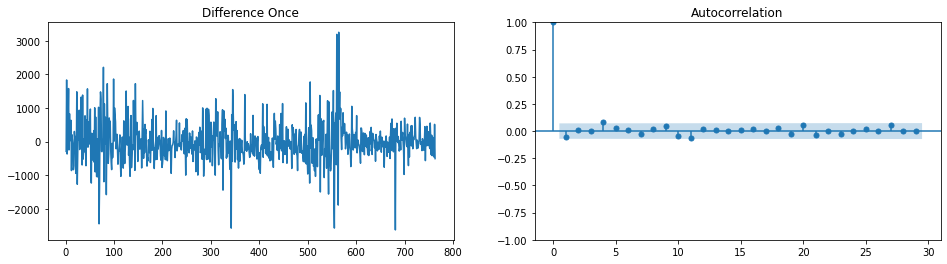

In [25]:
diff = df.Open.diff().dropna()

fig, (ax1, ax2) =plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff, ax =ax2);


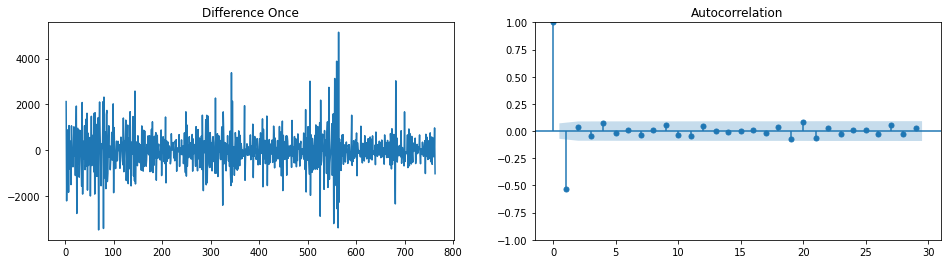

In [24]:
diff = df.Open.diff().diff().dropna()

fig, (ax1, ax2) =plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff, ax =ax2);


# since lag is increasing to negative side we'll difference only once 

> Checking with package

In [28]:
import pmdarima
pmdarima.arima.utils.ndiffs(df.Open, test="adf")

1

**P**

p is the order of Auto regressive term. It refers to the number of lags that can be used as predictors

We can find the required AR terms by inspecting the Partial AutoCorrelation(PACF) plot

as PACF represents the correlation between time seires and lag 

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf

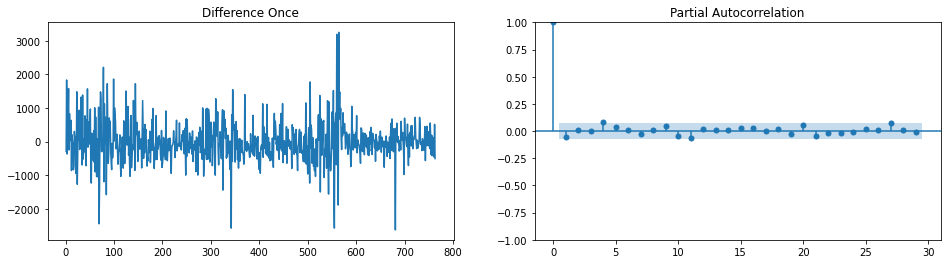

In [30]:

diff = df.Open.diff().dropna()

fig, (ax1, ax2) =plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference Once")
plot_pacf(diff, ax =ax2);



**We can observe that  PACF lag 4 is significant line above**

**q**

q is the order of the moving average (MA) term. It refers to the number of lagged forecast errors that should go into ARIMA model 

Here We can look at the ACF plot for the number of MA terms

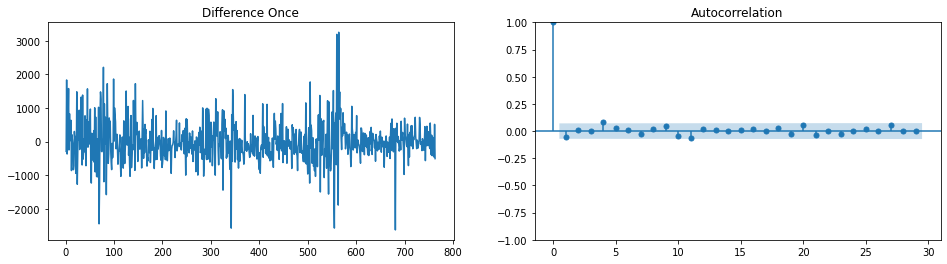

In [31]:
diff = df.Open.diff().dropna()

fig, (ax1, ax2) =plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff, ax =ax2);


**Fitting the ARIMA Model**

In [63]:
from statsmodels.tsa.arima.model import ARIMA

#ARIMA MODEL

model = ARIMA(df.Open, order=(4,1,1))
result = model.fit()

In [64]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  764
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -5951.920
Date:                Tue, 21 Jun 2022   AIC                          11915.840
Time:                        13:41:12   BIC                          11943.664
Sample:                             0   HQIC                         11926.553
                                - 764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6070      0.195      3.111      0.002       0.225       0.989
ar.L2          0.0816      0.025      3.315      0.001       0.033       0.130
ar.L3         -0.0440      0.031     -1.403      0.1

# Plotting the residual errors

(array([1.83821211e-04, 4.83104366e-07, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.41552183e-07]),
 array([-2717.04076735,  2701.66630938,  8120.37338612, 13539.08046285,
        18957.78753959, 24376.49461632, 29795.20169306, 35213.90876979,
        40632.61584653, 46051.32292326, 51470.03      ]),
 <BarContainer object of 10 artists>)

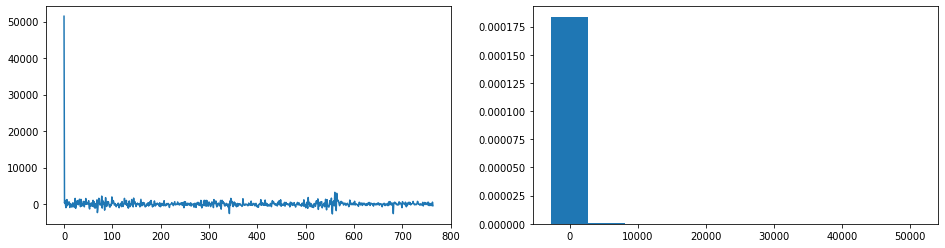

In [65]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) =plt.subplots(1,2,figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

## Actual V/S Fitted

In [66]:
from statsmodels.graphics.tsaplots import plot_predict


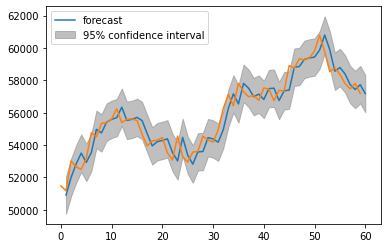

In [67]:
plot_predict(result,start=1,end=60,dynamic=False);
plt.plot(df['Open'][:60])
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'scatterplot'